In [1]:
import pandas as pd
from scipy import stats
import numpy as np 
import seaborn as sns
from random import randint, random
import matplotlib.pyplot as plt

## Setup

In [2]:
def sample_group_sizes(n_groups, n_individuals):
    """
    distribute the individauls in n_groups groups
    """
    
    sizes = []
    left = n_individuals
    for g in range(n_groups):
        if g == n_groups - 1:
            sizes.append(left)
        else:
            size = randint(1, left - n_groups + g)
            sizes.append(size)
            left -= size

    return sizes

In [3]:
G = 6 # number of groups
T = 60 # number of time periods
N = 300 # number of individuals
K = 100 # number of tickets that can be sold (capacity of plane)
N_EVALS = 0
    
wtp_g = stats.halfnorm.rvs(loc=4, scale=4, size=G) # location of wtp distribution for each group
wtps_g = stats.halfnorm.rvs(loc=2, scale=2, size=G) # scale of wtp distribution for each group

group_sizes = sample_group_sizes(G, N) # randomList(G, N)  #np.random.dirichlet([1]*G)

<BarContainer object of 6 artists>

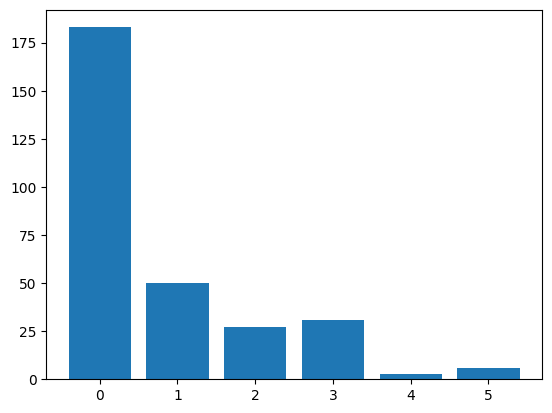

In [8]:
plt.bar(range(G), group_sizes)

In [9]:
occ_prob_g_t = np.zeros((G, T))

## Looking at the Resulting Distributions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


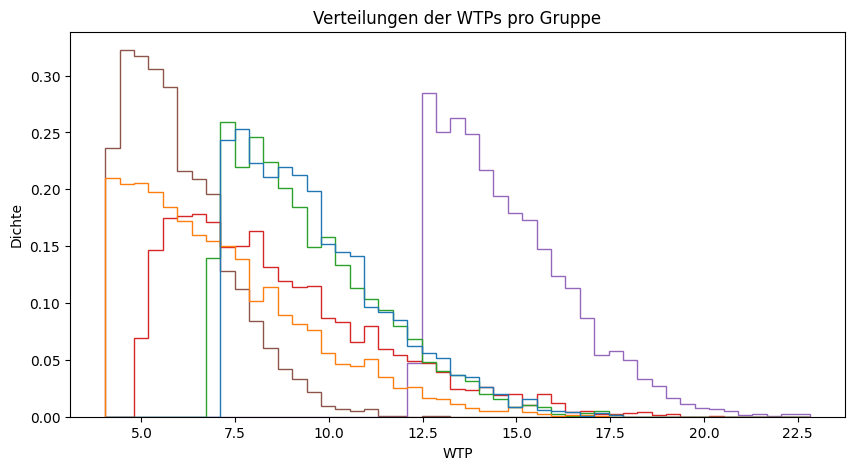

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
r = stats.halfnorm.rvs(size=(N*10, G), scale=wtps_g, loc=wtp_g)
ax.hist(r, density=True, bins='auto', histtype='step', alpha=1)
# ax.set_xlim([x[0], x[-1]])

ax.legend(loc='best', frameon=False)
ax.set_title('Verteilungen der WTPs pro Gruppe')
ax.set_xlabel('WTP')
ax.set_ylabel('Dichte')
plt.show()

In [11]:
wtp_sample = stats.halfnorm.rvs(loc=wtp_g, scale=wtp_g, size=(N, G))

In [12]:
F = 2

def init_occurenc_probs(T, group_sizes) -> list[list[int]]:
    occurences = []

    for g in group_sizes:
        start = np.random.choice(range(0,59))
        end = np.random.choice(range(start+1,60))

        probs = stats.beta.rvs(1, 1, size=end-start)
        probs = F * probs / probs.sum()

        occurences.append(
            [0]*start +
            list(probs) +
            [0]*(T-end)
            # randomList(end-start, g) + 
        )

    return occurences


In [13]:
occ = np.array(init_occurenc_probs(T, group_sizes))

In [14]:
wtp = [stats.halfnorm.rvs(loc=wtp_g[idx], scale=wtps_g[idx], size=g) for idx, g in enumerate(group_sizes)]

In [15]:
wtp_group_mean = wtp_sample.mean(axis=0)

Text(0.5, 1.0, 'Occurence Probability of groups over time')

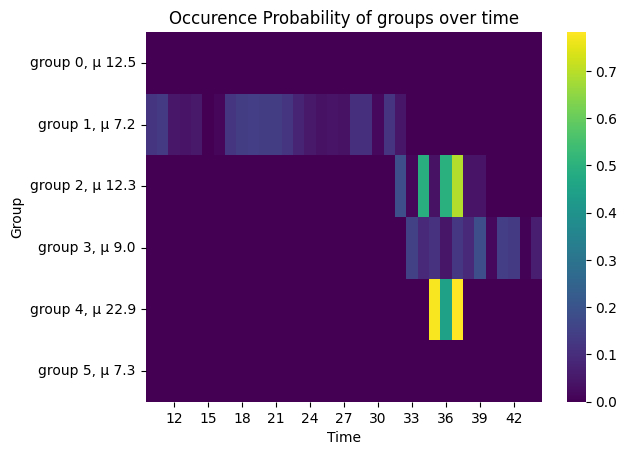

In [17]:
fig, ax = plt.subplots(1, 1)
sns.heatmap(occ, ax=ax, cmap='viridis')
ax.set_xlabel('Time')
ax.set_ylabel('Group')
ax.set_yticklabels(['group {}, µ {}'.format(i, round(wtp_group_mean[i], 1)) for i in range(G)])

ax.set_xlim([10, 45])

# rotate y labels
plt.yticks(rotation=0)

ax.set_title('Occurence Probability of groups over time')

In [18]:
# n_offered = np.array(randomList(T, K) )
n_offered = np.array([100]*T)

In [27]:
price = np.random.normal(2, 2, size=T)    

# check: for a price of 0 we should get N individuals who are willing to pay
# price = [2] * T

In [95]:
def objective_fn(individuals:pd.DataFrame, price:np.ndarray[float], n_offered:np.ndarray[int]):

    individuals_c = individuals.copy()
    tickets_left = K
    profit = 0
    n_appearances = 0

    for t in range(T):

        willing_to_pay = []
        appearing = []
        # individuals_c["weight"] = occ[0, t]
 
        for g in range(G):
            n_occ = stats.binom.rvs(group_sizes[g], occ[g, t])
            n_appearances += n_occ
            appearing += individuals_c.loc[
                (individuals_c["bought"] == False) & 
                (individuals_c["group"] == g)].sample(n=n_occ).to_dict(orient='records')


        # for i in individuals_c.loc[individuals_c["bought"] == False].to_dict(orient='records'):
            # if random() < occ[i["group"], t]:
            #     appearing.append(i)
            #     n_appearances += 1
        
        willing_to_pay = [i for i in appearing if i["wtp"] >= price[t]]

        # sample the individuals_c to whom the ticket are sold.
        ticket_sold_to_idx = np.random.choice(
            range(len(willing_to_pay)), 
            min(len(willing_to_pay), int(n_offered[t]), tickets_left), 
            replace=False)
        
        tickets_left -= len(ticket_sold_to_idx)
        profit += len(ticket_sold_to_idx) * price[t]

        for idx in ticket_sold_to_idx:
            individuals_c.loc[(willing_to_pay[idx]["ind"]) & (willing_to_pay[idx]['ind']), "bought"] = True

        # filter individuals who bought a ticket
        # for i in individuals

        if tickets_left == 0:
            print("all tickets sold")
            break

    print(n_appearances)
    return profit

In [96]:
profit = objective_fn(individuals, price, n_offered)

all tickets sold
103


164.01121340249233

In [53]:
def mutate_price(price:np.ndarray) -> np.ndarray:
    """
    mutate the price vector by adding a random value at a random position
    """
    price_new = price.copy()
    price_idx = randint(0, T-1)

    price_new[price_idx] = max(0, price[price_idx] + np.random.normal(0, price.std()))
    
    return price_new

In [58]:
def mutate_n_tickets_sold(n_tickets_sold:np.ndarray, resample_length: int=3):
    """
    mutinit_occurencesate the n_tickets sold by resampling a section of the genes
    """
    n_tickets_sold_new = n_tickets_sold.copy()


    # resample_length = resample_length
    idx = randint(0, T-1)

    n_tickets_sold_new[idx] = np.random.randint(0,100)#randomList(resample_length, K)

    return n_tickets_sold_new

In [55]:
def recombine_price(price1:np.ndarray, price2:np.ndarray):
    """
    recombine two prices
    """
    price_new = price1.copy()

    idx = randint(0, T-1)

    price_new[:idx] = price1[:idx]
    price_new[idx:] = price2[idx:]

    return price_new

def recombine_n_tickets_sold(n_tickets_sold1:np.ndarray, n_tickets_sold2:np.ndarray):
    """
    recombine two n_tickets_sold
    # Note that this recombination can lead to invalid solutions that may exceed capacity
    """
    n_tickets_sold_new = n_tickets_sold1.copy()

    idx = randint(0, T-1)

    n_tickets_sold_new[:idx] = n_tickets_sold1[:idx]
    n_tickets_sold_new[idx:] = n_tickets_sold2[idx:]

    return n_tickets_sold_new

In [56]:
def init_individual():
    return np.random.normal(5, 2, size=T), np.array(sample_group_sizes(T, K))

## Testing Mutation

In [103]:
best = 0
best_price = None
best_offered = None
improvements = []

for i in range(100):
    price, n_offered = init_individual()

    o = objective(price, n_offered)

    price_mut = mutate_price(price)
    # n_offered_mut = mutate_n_tickets_sold(n_offered)

    o_mut = objective(price_mut, n_offered)

    # if o_mut > o:
    #     best += 1
    #     print(o_mut, o)

    improvements.append(o_mut-o)

# if o > best:
#     best = o
#     best_price = price
#     best_offered = n_offered
#     print(o)

## testing recombination

In [ ]:
best = 0

for i in range(100):
    price1, n_offered1 = init_individual()
    price2, n_offered2 = init_individual()

    o1 = objective(price1, n_offered1)
    o2 = objective(price2, n_offered2)

    price_new = recombine_price(price1, price2)
    n_offered_new = recombine_n_tickets_sold(n_offered1, n_offered2) 

    o_new = objective(price_new, n_offered_new)

    if o_new > o1 and o_new > o2:
        best += 1
        print(o_new, o1, o2)

## Implementing GA

In [44]:
def roulette_selection(individuals, objs: list[float], n_selected: int):
    """
    select individuals based on their objective values
    -> roulette wheel selection
    """
    n = len(individuals)

    # sort individuals by objective value
    sorted_individuals = [ind for _, ind in sorted(zip(objs, individuals), key=lambda pair: pair[0], reverse=True)]
    # select the best n_selected individuals
    return np.array(sorted_individuals[:n_selected])


    # normalize objective values
    objs_arr = np.array(objs)
    objs_norm = objs_arr/objs_arr.sum()

    selected_id =  np.random.choice(range(len(individuals)), size=n_selected, p=objs_norm)

    return np.array([individuals[i] for i in selected_id])


In [ ]:
# exponential decay of mutation rate

MUT_START = 0.3
MUT_DECAY = 0.05

t = np.arange(20)

# plt.plot(t, MUT_START*MUT_DECAY**t)
plt.plot(t, MUT_START*np.exp(-0.05*t))

In [61]:
individuals = pd.DataFrame([{"group": g, "ind": idx, "wtp": wtp[g][idx], "bought": False} for g in range(len(group_sizes)) for idx in range(group_sizes[g])])

In [98]:
N_ITER = 20 # number of iterations
POP_SIZE = 100 # population size
N_CHILDREN = 100 # number of children to generate from the population
MUTATION_RATE = 0.30 # when doing constant mutation: probability of mutation
REAMPLE_LENGTH = 3
N_EVALS = 0 # number of evaluations of the objective function

# where to start the mutation rate
MUT_START = 0.3
MUT_DECAY = 0.05


population_current = np.array([init_individual() for _ in range(POP_SIZE)])
population_hist = [population_current]
obj_stats = []

for i in range(N_ITER):
    objs = [objective_fn(individuals, *ind) for ind in population_current]
    objs_norm = objs/sum(objs)
    obj_stats.append(objs)

    print(np.array(objs).mean())

    children = []
    valid = 0
    # for j in range(N_CHILDREN):

    # generate children until we have N_CHILDREN valid children
    while valid < N_CHILDREN:

        # sample two parents based on their objective values
        parents = np.random.choice(np.array(range(POP_SIZE)), size=2, p=objs_norm, replace=False)
        
        # recombine parents to obtain new price
        child_price = recombine_price(population_current[parents[0], 0, :], population_current[parents[1], 0, :])
        
        # recombine parents to obtain new n_tickets_sold
        child_offered = recombine_n_tickets_sold(population_current[parents[0], 1, :], population_current[parents[1], 1, :])
# 
        # check if the child is valid
        if sum(child_offered) <= K:
            valid += 1
            children.append([child_price, child_offered])

    # mutate the children
    for child in children:
        # if np.random.rand() < MUTATION_RATE:
        if np.random.rand() < MUT_START*np.exp(-MUT_DECAY*i):
            child[0] = mutate_price(child[0])
            child[1] = mutate_n_tickets_sold(child[1], resample_length=REAMPLE_LENGTH)

    objs_new = [objective_fn(individuals, *ind) for ind in children]

    # temporarily add children to population
    population_current = np.concatenate([population_current, children], axis=0)

    # reduce population size again
    population_current = roulette_selection(population_current, np.concatenate([objs, objs_new]), n_selected=POP_SIZE)

    population_hist.append(population_current)

576
612
599
601
613
623


KeyboardInterrupt: 

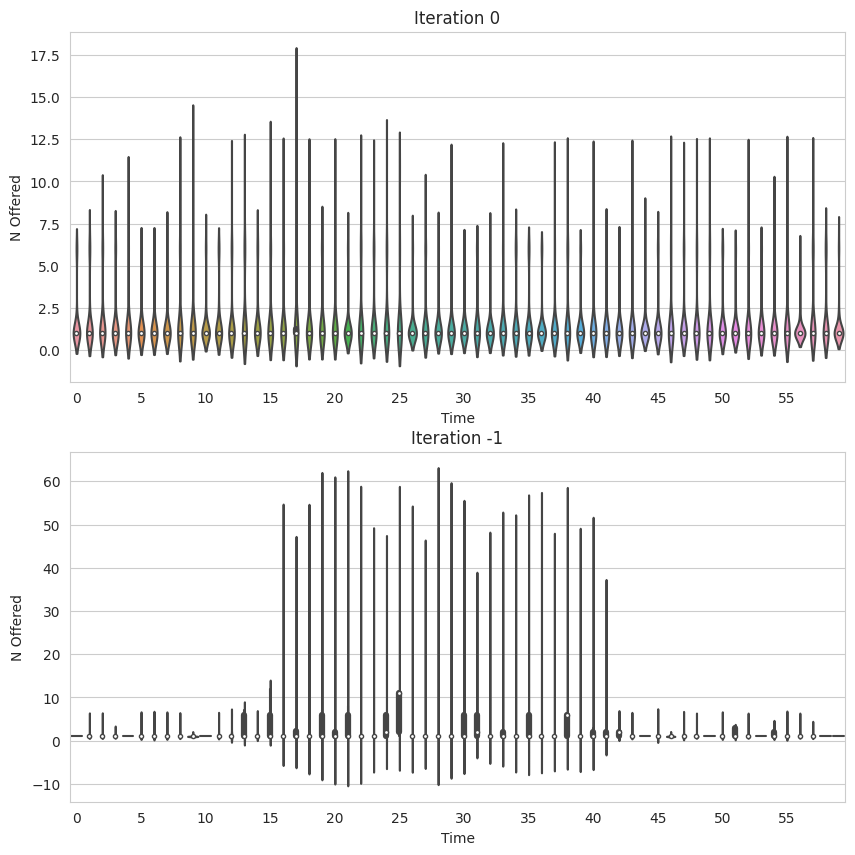

In [151]:
# visualize children
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
# population_current


# title
ax[1].set_title('Iteration -1')
ax[0].set_title('Iteration 0')
sns.violinplot(data=population_hist[-1][:,1,:], ax=ax[1])
sns.violinplot(data=population_hist[0][:,1,:], ax=ax[0])
for i in range(2):
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('N Offered')
    ax[i].set_xticks(range(0, T, 5))


# tick frequency

In [137]:
obj_stats = np.array(obj_stats)

In [138]:
res = pd.DataFrame(obj_stats).reset_index().melt(id_vars='index').rename(columns={'index': 'iteration', 'variable': 'individual', 'value': 'objective'})

In [ ]:
pd.DataFrame(obj_stats).mean(axis=1).plot()

<Axes: title={'center': 'Objective values over iterations'}, xlabel='Iteration', ylabel='Objective value'>

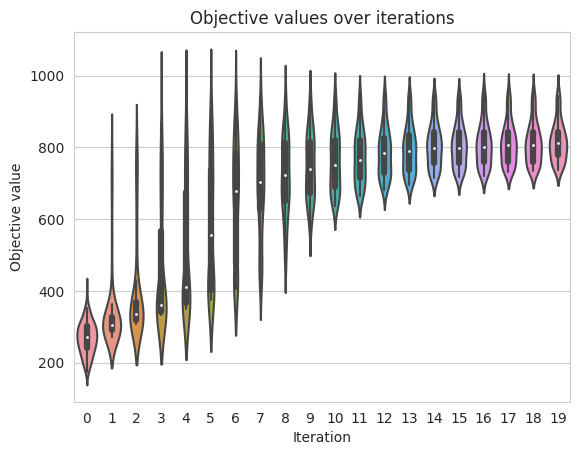

In [148]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1)
ax.set_title('Objective values over iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('Objective value')
sns.violinplot(data=obj_stats.T)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(data=res, x='iteration', y='objective', hue='individual', ax=ax)
# plot mean value
sns.lineplot(data=res, x='iteration', y='objective', ax=ax, color='red')

In [ ]:
# 2 * T * pop_size * it

In [ ]:
np.random.choice()